# Objective

Author: Kate Lassiter

## Preprocessing of Accelerometer Data
- Signal Processing
- Filter noise using a high-pass or low-pass filter (to remove high-frequency noise)
- Use normalization or standardization techniques to scale data
- Compare the two filtering approaches to determing which should be used to preprocess our accelromenter wrist data.


## Visualization 
Shown below is SciPy’s Butterworth Digital And Analog Filter applied to the wrist signal, using a high/low frequency filter; plotting velocity accleration and position. 


### Data Interpretation
When measuring accelerometer data from the lower back, the X-axis typically represents movement forwards and backwards (along the body's sagittal plane), the Y-axis re whypresents side-to-side movement (lateral flexion), and the Z-axis measures up-down movement (extension and flexion) relative to the sensor placement on the lower back. 
Breakdown of axes: 
- X-axis (Forward/Backward):
    - A positive value indicates movement towards the front of the body, while a negative value indicates movement towards the back. 
- Y-axis (Sideways):
    - A positive value usually indicates movement towards the right side of the body, and a negative value indicates movement towards the left side. 
- Z-axis (Up/Down):
    - A positive value represents movement upwards (extension), while a negative value indicates movement downwards (flexion).
 
### Code

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os

# Generating time parameters
def time_params(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    initial_time=pd.Timedelta(seconds=0)
    time_chg = (df['timestamp'] - df['timestamp'].shift(1)).fillna(initial_time)
    time_chg = time_chg.dt.total_seconds() 
    time_avg = time_chg.mean()  
    samp_freq_ = 1.0 / time_avg  
    time_ = np.cumsum(time_chg) 
    return df, samp_freq_, time_, time_avg

In [3]:
# Noise filtering
def freq_filter(df, freq_cut, fs, degree=4,type='high'):
    norm_cut = freq_cut /  (0.5 * fs)
    g, f = butter(degree, norm_cut, btype=type, analog=False)
    return filtfilt(g, f, df)

In [5]:
# Extract velocity and position
def position_velocity(x_, y_, z_, avg_time):
    vel_x = avg_time*np.cumsum(x_)
    vel_y = avg_time*np.cumsum(y_)
    vel_z = avg_time*np.cumsum(z_) 
    pos_x = avg_time*np.cumsum(np.append(0.0,(vel_x[:-1] + vel_x[1:]) / 2.0))
    pos_y = avg_time*np.cumsum(np.append(0.0,(vel_y[:-1] + vel_y[1:]) / 2.0))
    pos_z = avg_time*np.cumsum(np.append(0.0,(vel_z[:-1] + vel_z[1:]) / 2.0))
    return vel_x, vel_y, vel_z, pos_x, pos_y, pos_z

In [7]:
def plotter(time, x_vel,y_vel,z_vel,x_pos,y_pos,z_pos,x_new,y_new,z_new):
    # Velocity vs time
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(time, x_vel, label='X', color=(0, 0, 1, 0.7))
    plt.plot(time, y_vel, label='Y', color=(1, 0, 0, 0.7))
    plt.plot(time, z_vel, label='Z', color=(0, 1, 0, 0.7))
    plt.legend()
    plt.xlabel('seconds')
    plt.ylabel('velocity (m/s)')
    plt.title('Velocity vs. Time: High-pass Filter')
    
    
    # Position vs time
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 2)
    plt.plot(time, x_pos, label='X', color=(0, 0, 1, 0.7))
    plt.plot(time, y_pos, label='Y', color=(1, 0, 0, 0.7))
    plt.plot(time, z_pos, label='Z', color=(0, 1, 0, 0.7))
    plt.legend()
    plt.xlabel('seconds')
    plt.ylabel('position (m)')
    plt.title('Position vs. Time: High-pass Filter')
    
    # Acceleration vs time
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 3)
    plt.plot(time, x_new, label='X', color=(0, 0, 1, 0.7))
    plt.plot(time, y_new, label='Y', color=(1, 0, 0, 0.7))
    plt.plot(time, z_new, label='Z', color=(0, 1, 0, 0.7))
    plt.legend()
    plt.xlabel('seconds')
    plt.ylabel(r'acceleration $(m/s^2$)')
    plt.title('Acceleration vs. Time: High-pass Filter')
    plt.show()

### Examine a single observation's hip sensor (high-frequency filter)

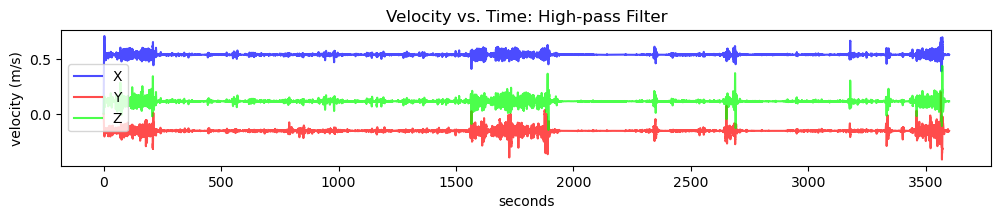

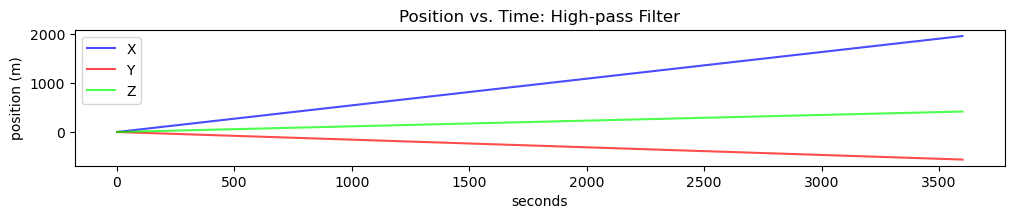

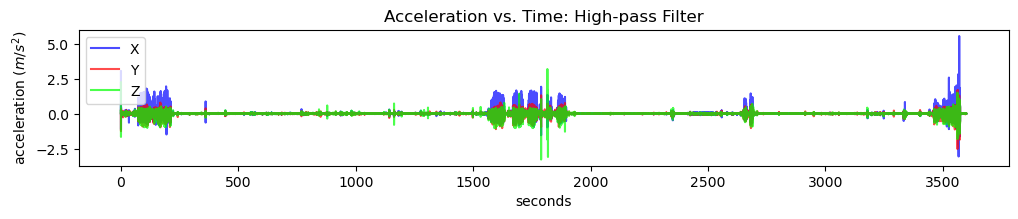

In [14]:
data=pd.read_csv("/XXXX/.csv")
data, samp_freq, time,time_avg = time_params(data)
cut_freq = 0.1  # increase cutoff = only get rid of high frequency noise
x_new = freq_filter(data['x'].values, cut_freq, samp_freq,type='high')
y_new = freq_filter(data['y'].values, cut_freq, samp_freq,type='high')
z_new = freq_filter(data['z'].values-9.8, cut_freq, samp_freq,type='high') #- 9.8 b/c gravity
x_vel, y_vel, z_vel, x_pos, y_pos, z_pos = position_velocity(x_new, y_new, z_new, time_avg)
plotter(time, x_vel,y_vel,z_vel,x_pos,y_pos,z_pos,x_new,y_new,z_new)   

### Examine same observation's wrist sensor (high-frequency filter)

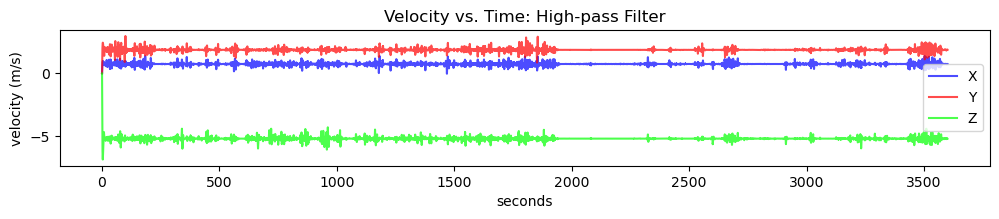

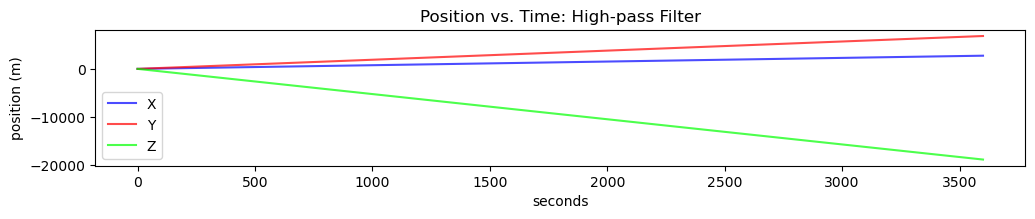

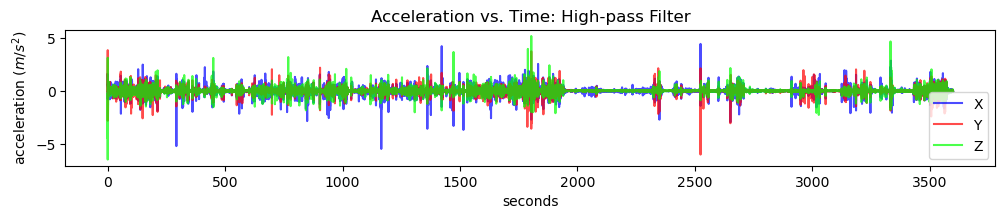

In [21]:
data=pd.read_csv("Downloads/OxWalk_Dec2022/Wrist_100Hz/P39_wrist100.csv") 
data, samp_freq, time, time_avg = time_params(data)
cut_freq = 0.1  # increase cutoff = only get rid of high frequency noise
x_new = freq_filter(data['x'].values, cut_freq, samp_freq,type='high')
y_new = freq_filter(data['y'].values, cut_freq, samp_freq,type='high')
z_new = freq_filter(data['z'].values-9.8, cut_freq, samp_freq,type='high') #- 9.8 b/c gravity
x_vel, y_vel, z_vel, x_pos, y_pos, z_pos = position_velocity(x_new, y_new, z_new, time_avg)
plotter(time, x_vel,y_vel,z_vel,x_pos,y_pos,z_pos,x_new,y_new,z_new)   

### Examine a single observation's hip sensor (low-frequency filter)

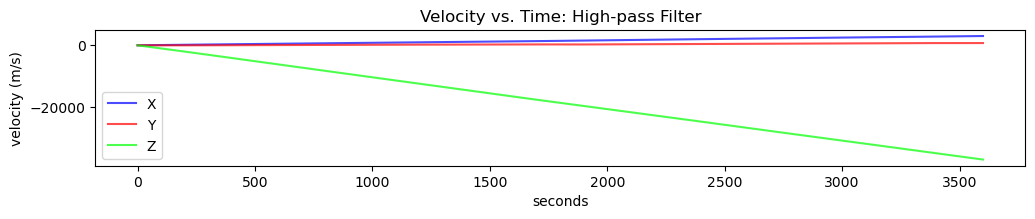

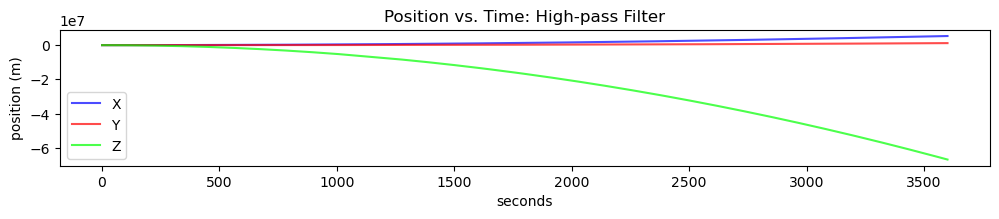

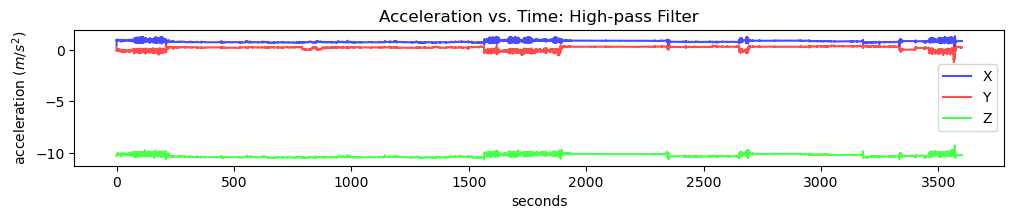

In [26]:
#Low frequency filter
data=pd.read_csv("Downloads/OxWalk_Dec2022/Hip_100Hz/P39_hip100.csv")
data, samp_freq, time,time_avg = time_params(data)
cut_freq = 2.0  # increase cutoff = only get rid of high frequency noise
x_new = freq_filter(data['x'].values, cut_freq, samp_freq,type='low')
y_new = freq_filter(data['y'].values, cut_freq, samp_freq,type='low')
z_new = freq_filter(data['z'].values-9.8, cut_freq, samp_freq,type='low') #- 9.8 b/c gravity
x_vel, y_vel, z_vel, x_pos, y_pos, z_pos = position_velocity(x_new, y_new, z_new, time_avg)
plotter(time, x_vel,y_vel,z_vel,x_pos,y_pos,z_pos,x_new,y_new,z_new)  

### Examine same observation's wrist sensor (low-frequency filter)

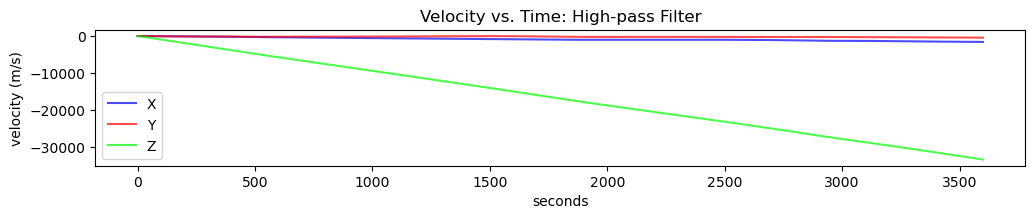

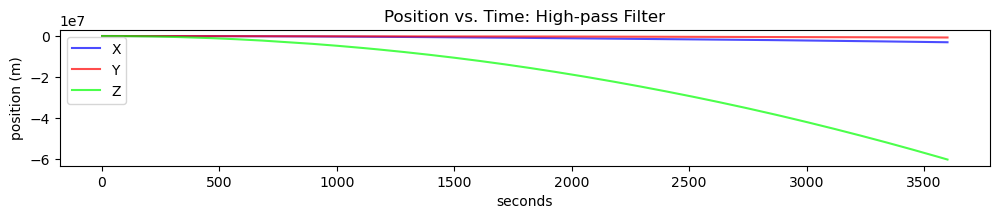

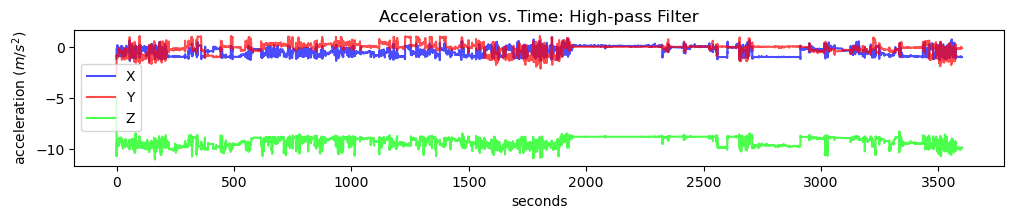

In [29]:
#Low frequency filter 
data=pd.read_csv("Downloads/OxWalk_Dec2022/Wrist_100Hz/P39_wrist100.csv") 
data, samp_freq, time, time_avg = time_params(data)
cut_freq = 2.0  # increase cutoff = only get rid of high frequency noise
x_new = freq_filter(data['x'].values, cut_freq, samp_freq,type='low')
y_new = freq_filter(data['y'].values, cut_freq, samp_freq,type='low')
z_new = freq_filter(data['z'].values-9.8, cut_freq, samp_freq,type='low') #- 9.8 b/c gravity
x_vel, y_vel, z_vel, x_pos, y_pos, z_pos = position_velocity(x_new, y_new, z_new, time_avg)
plotter(time, x_vel,y_vel,z_vel,x_pos,y_pos,z_pos,x_new,y_new,z_new)  

### Code to loop through each file

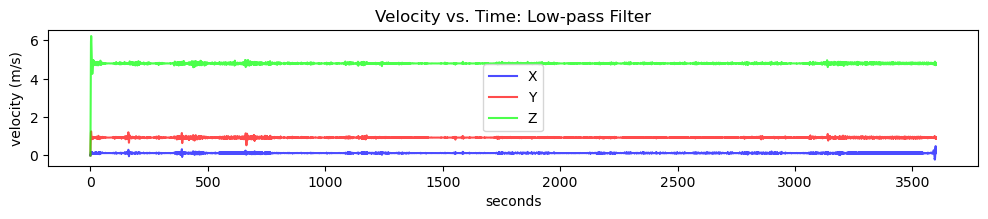

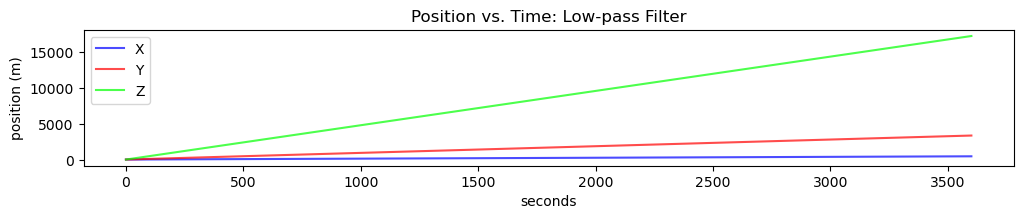

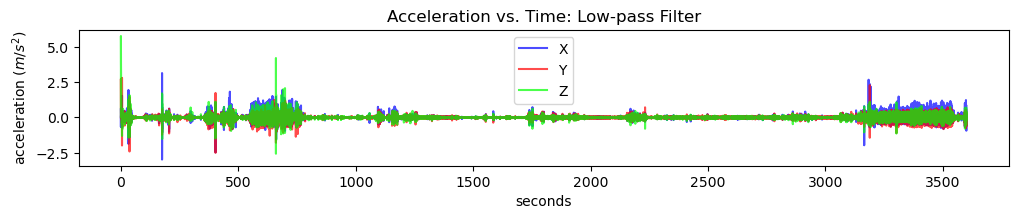

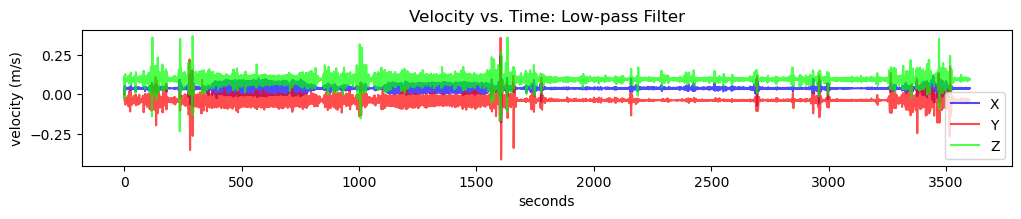

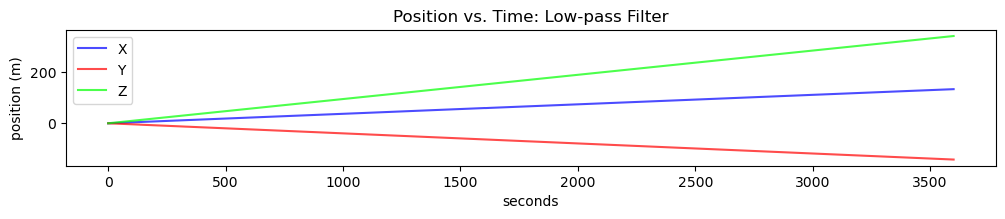

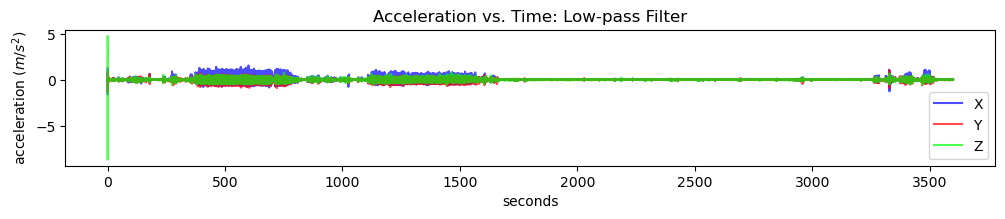

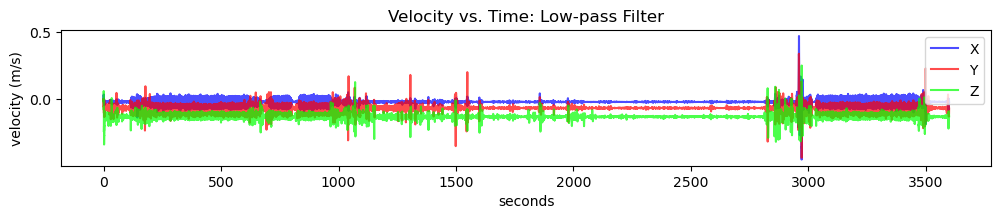

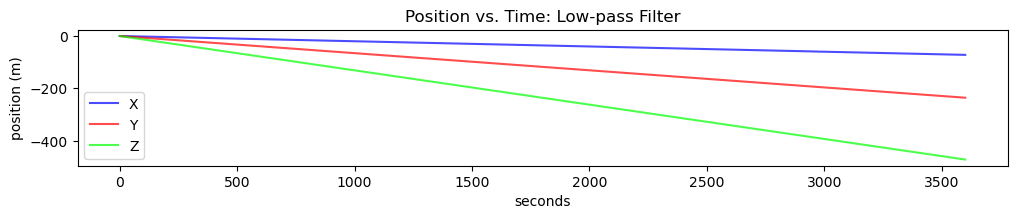

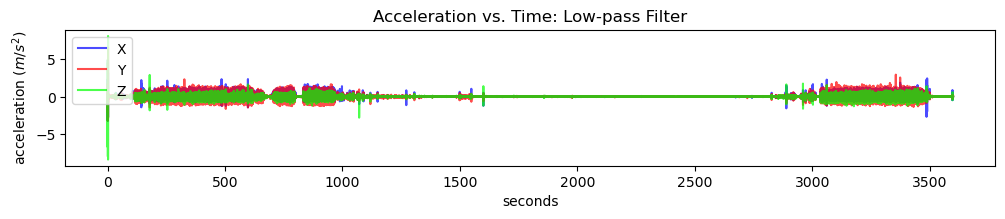

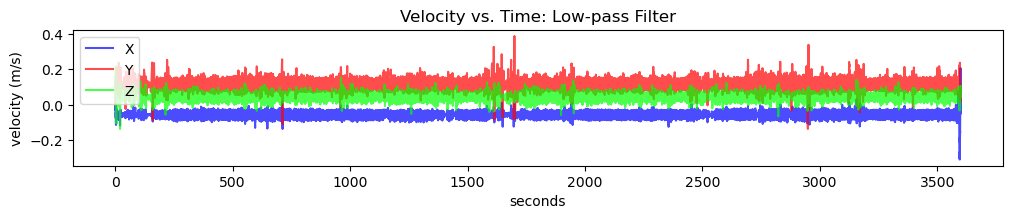

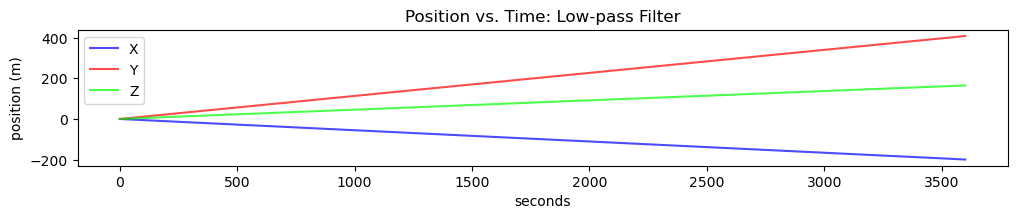

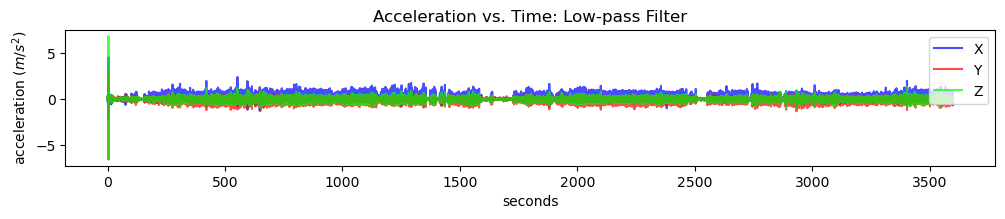

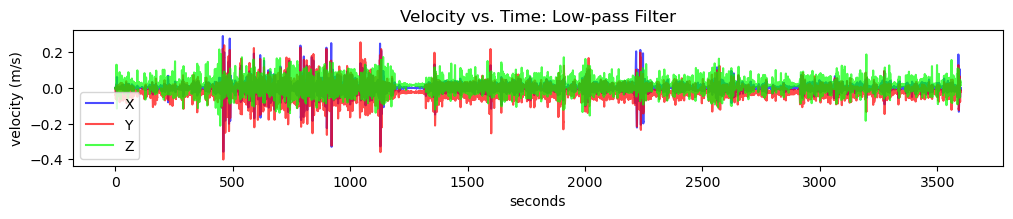

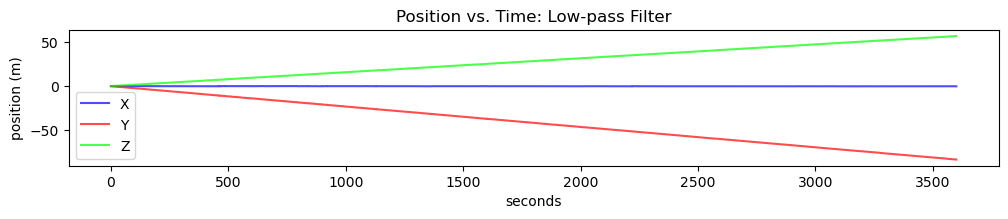

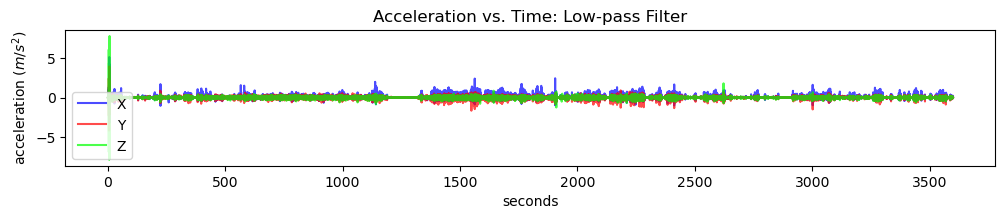

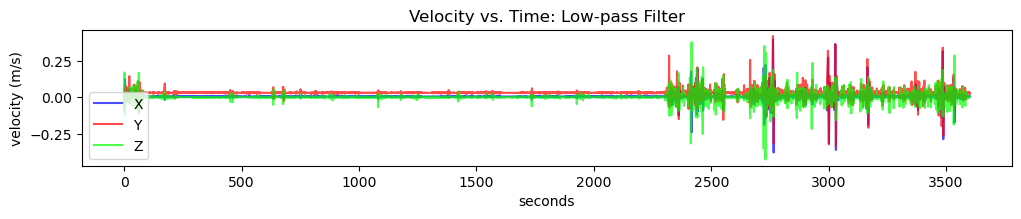

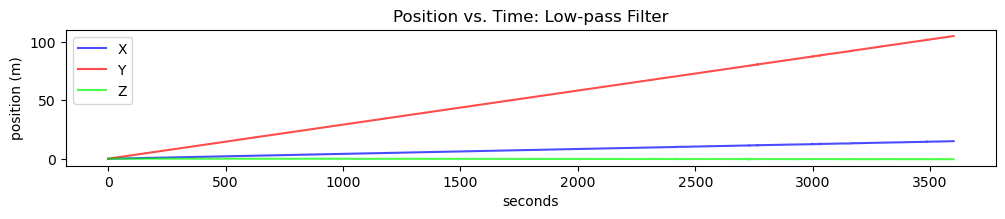

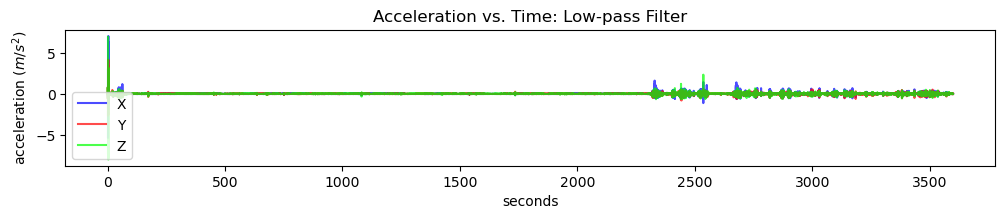

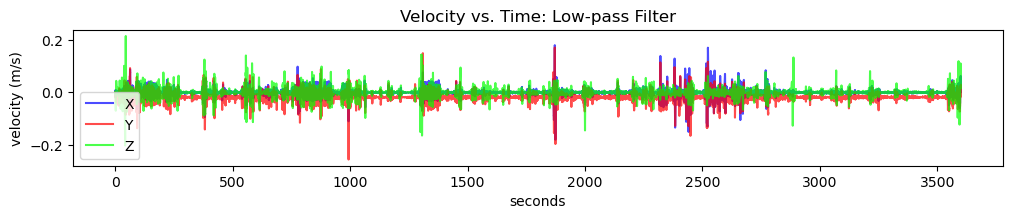

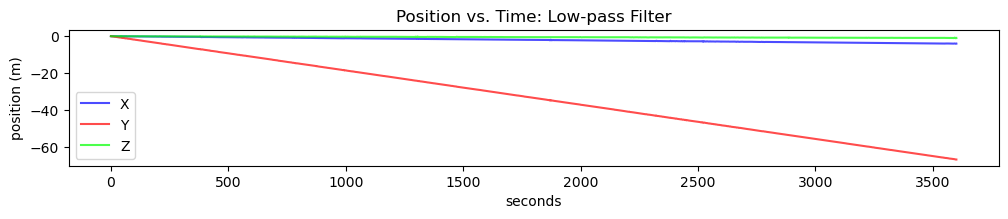

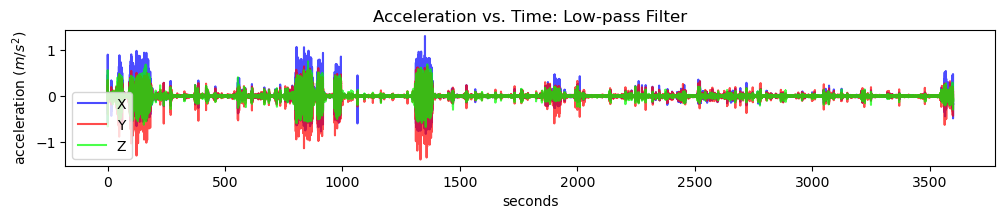

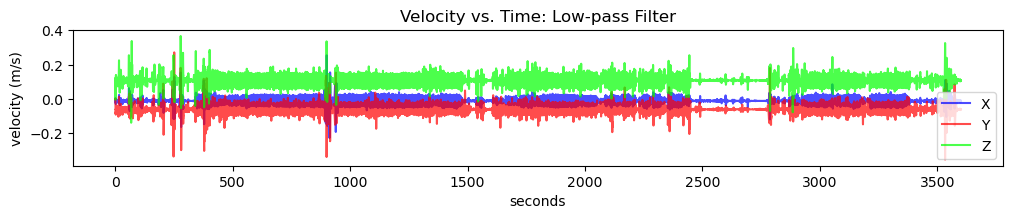

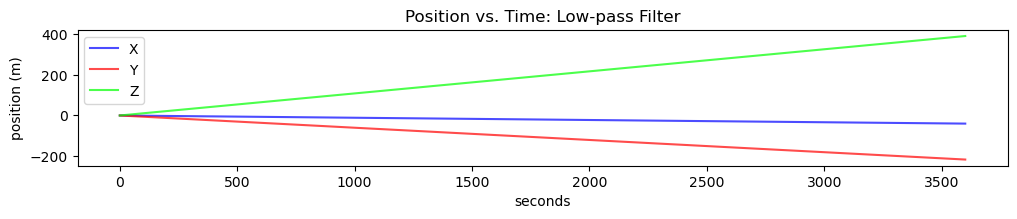

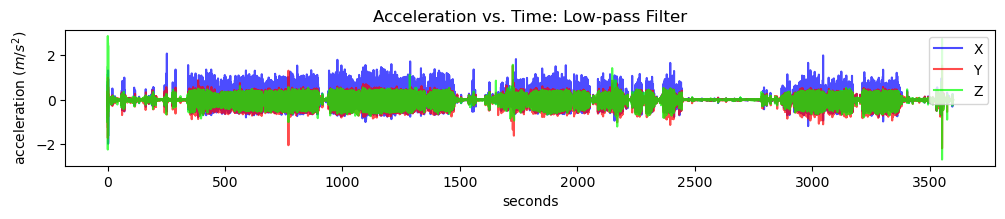

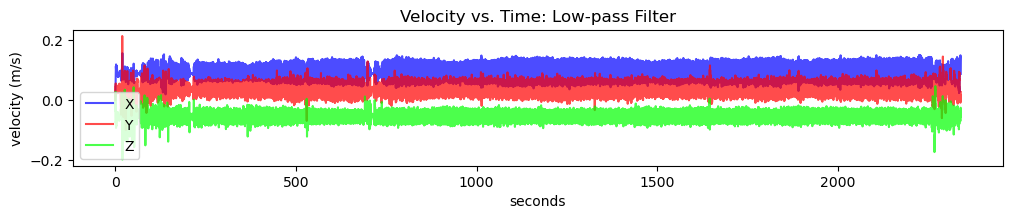

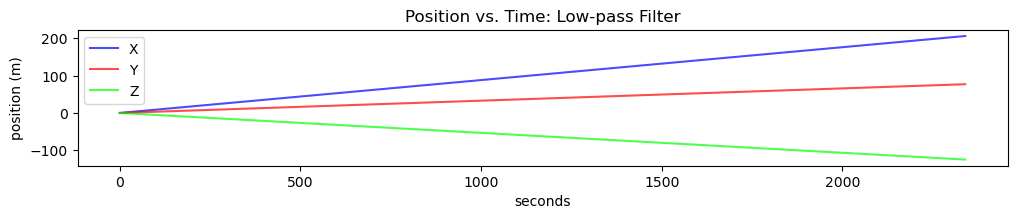

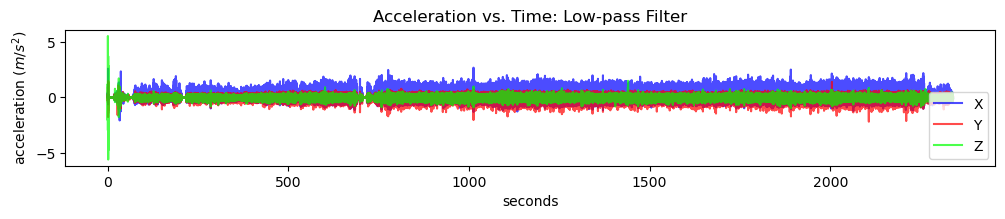

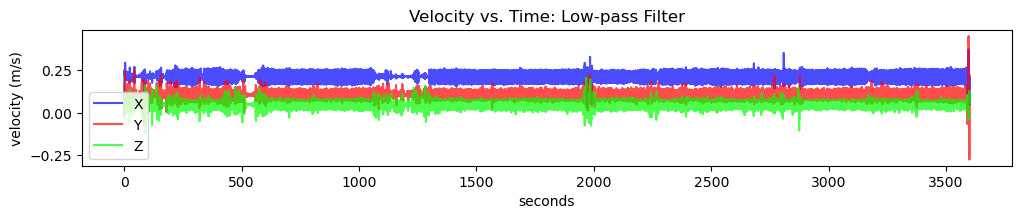

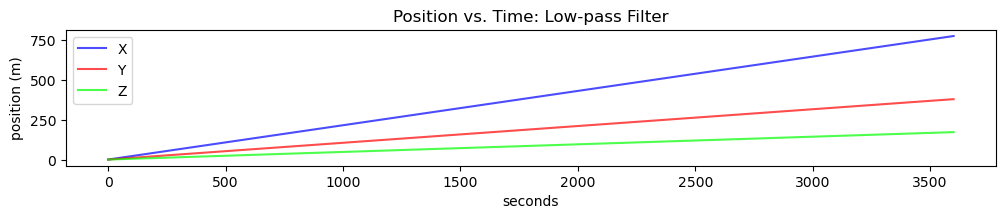

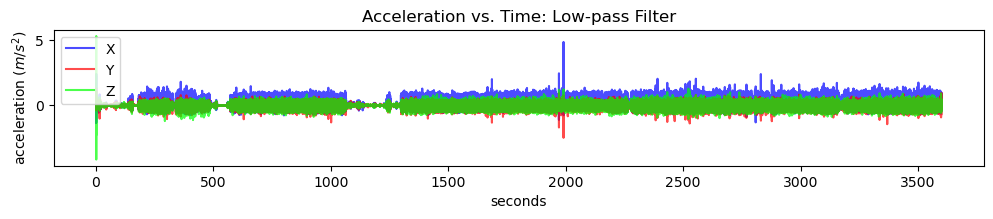

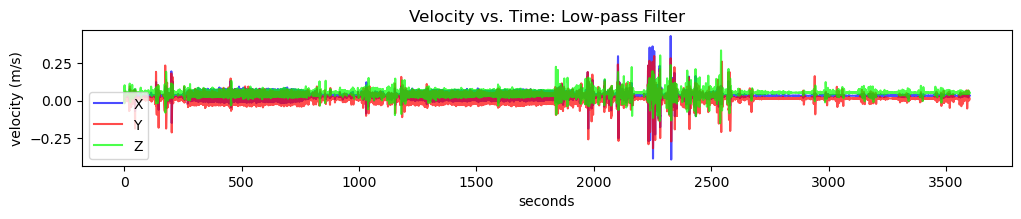

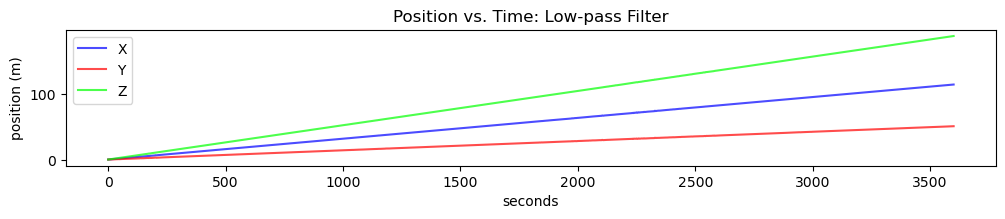

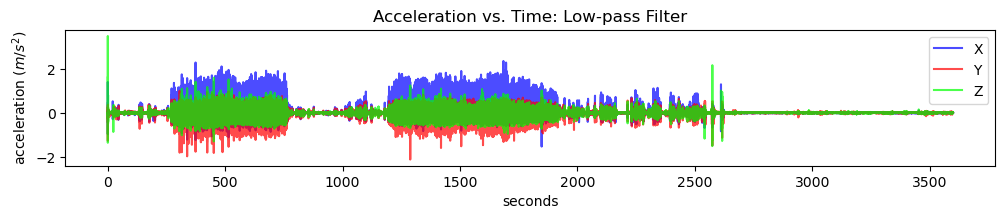

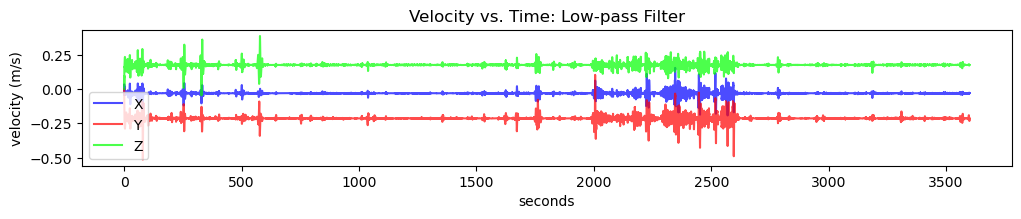

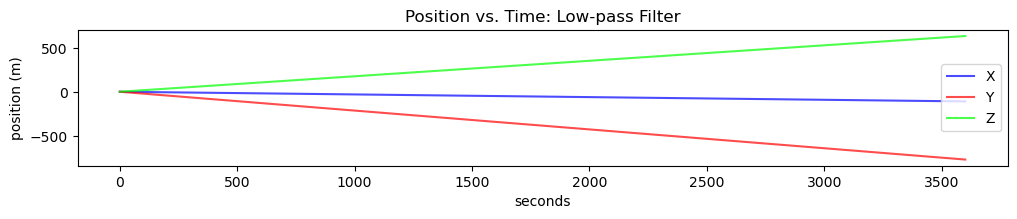

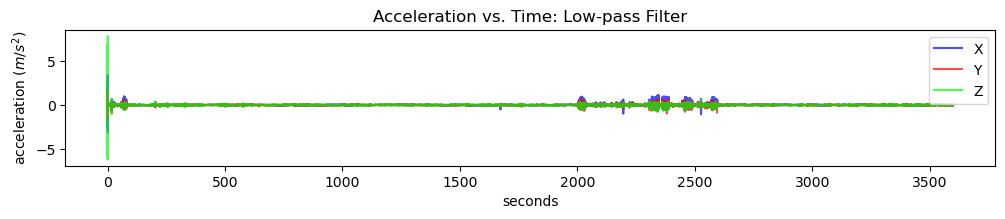

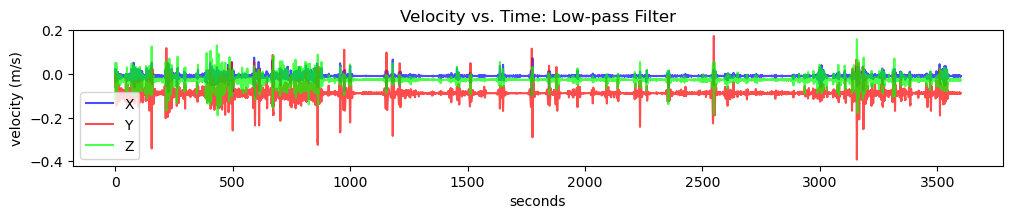

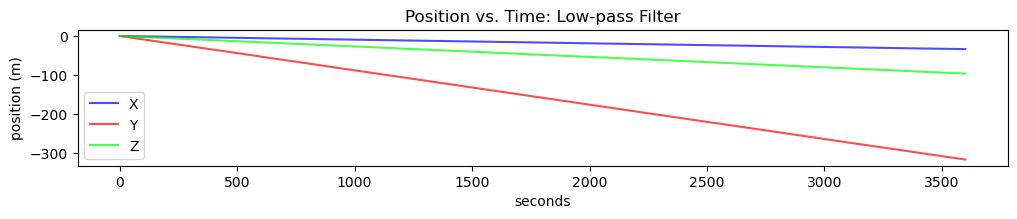

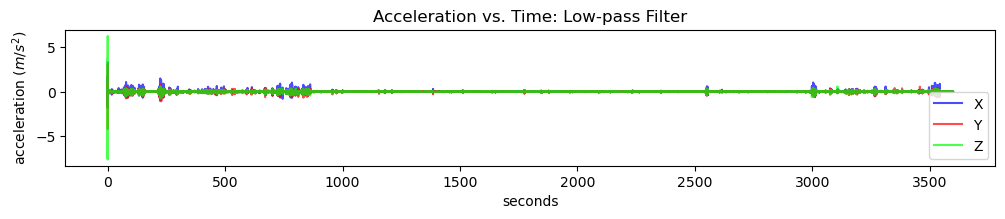

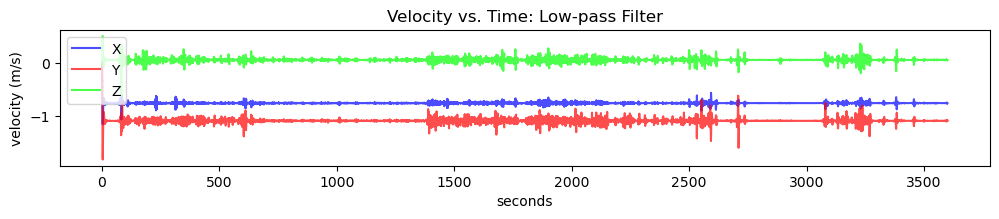

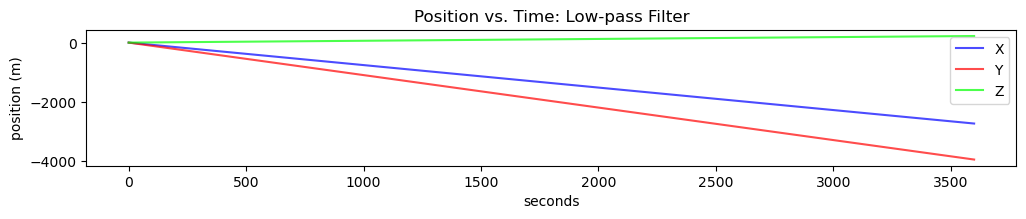

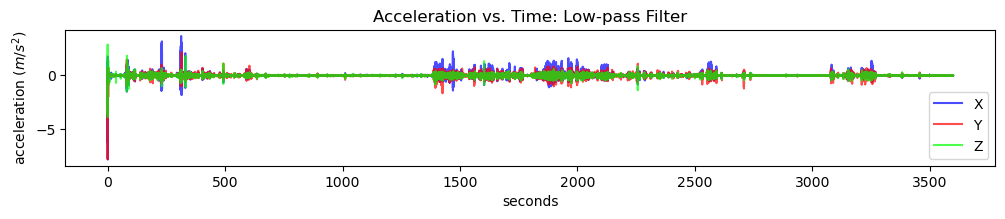

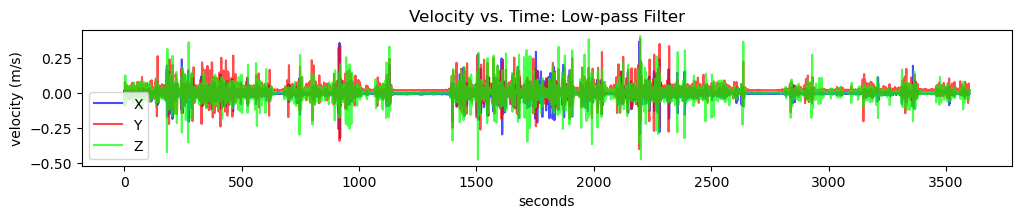

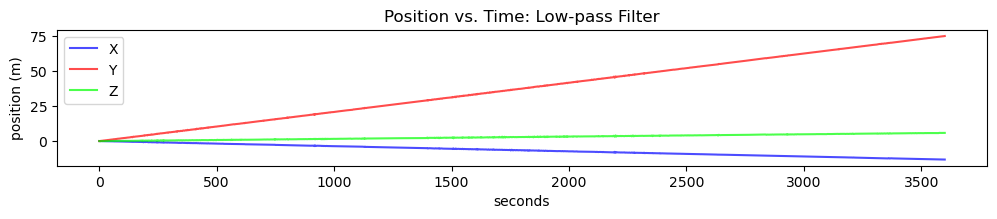

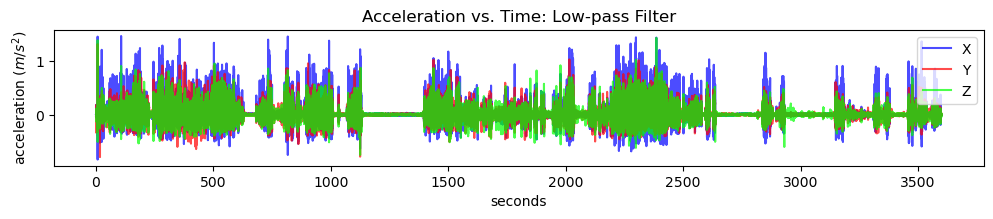

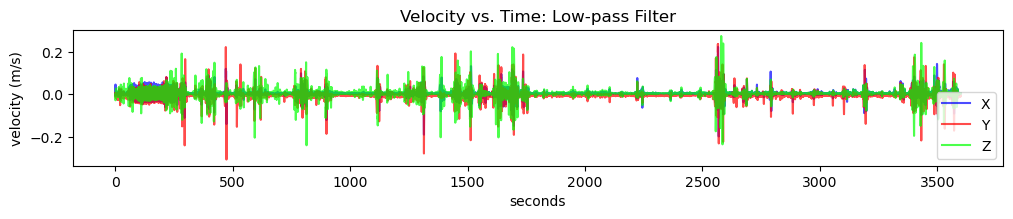

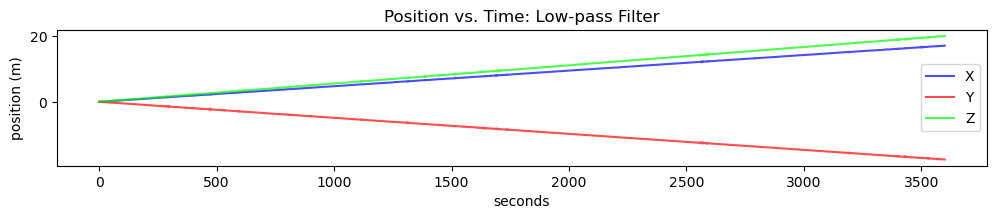

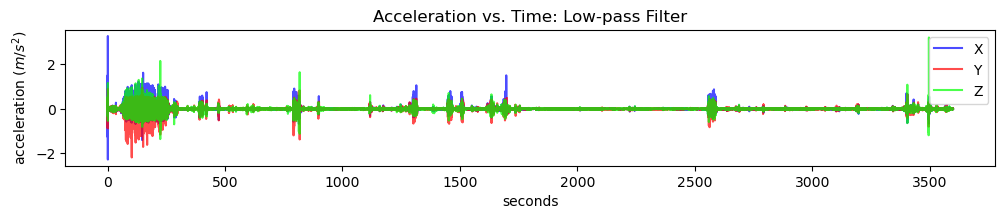

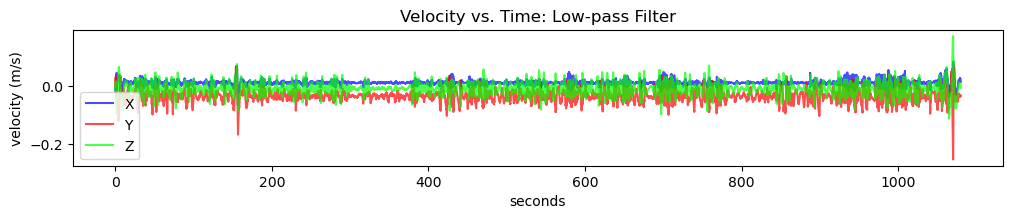

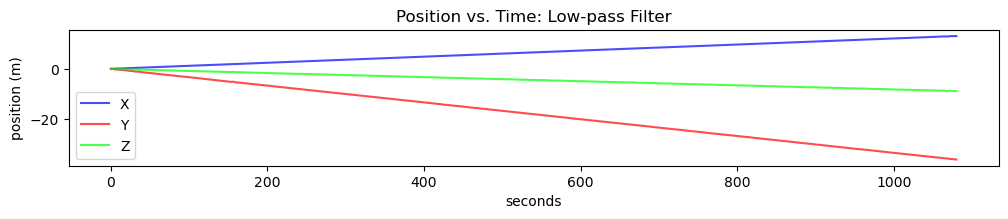

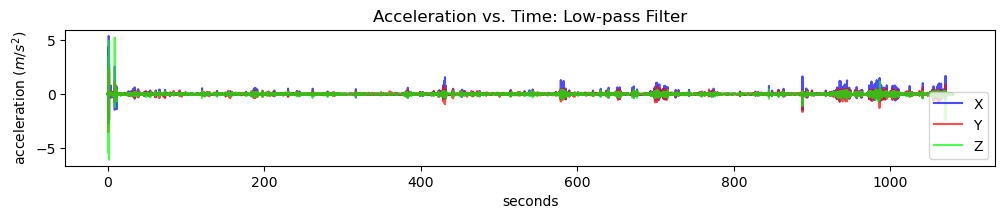

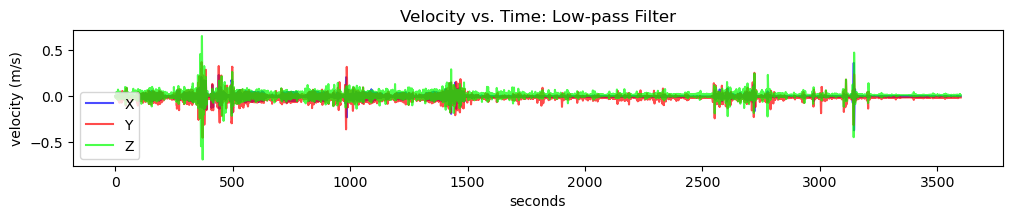

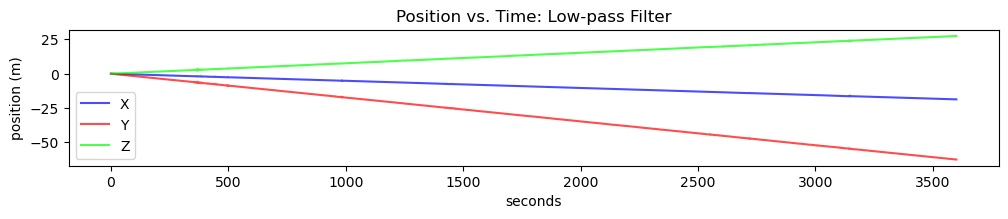

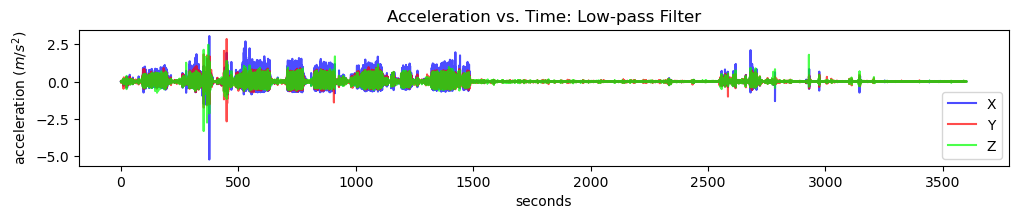

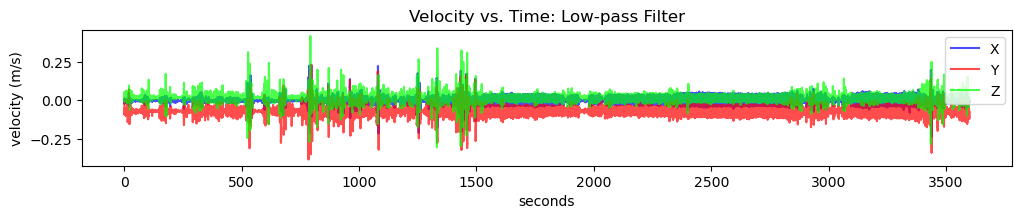

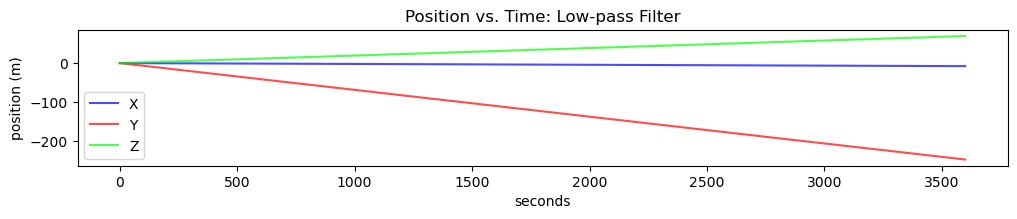

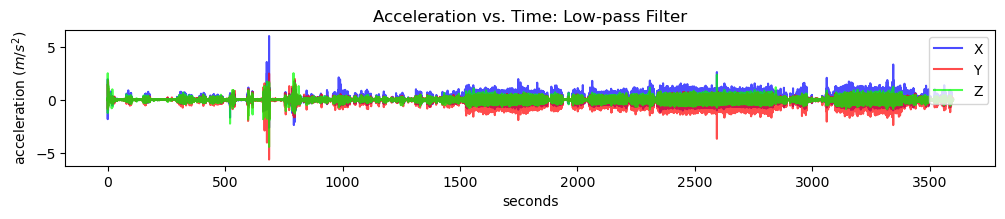

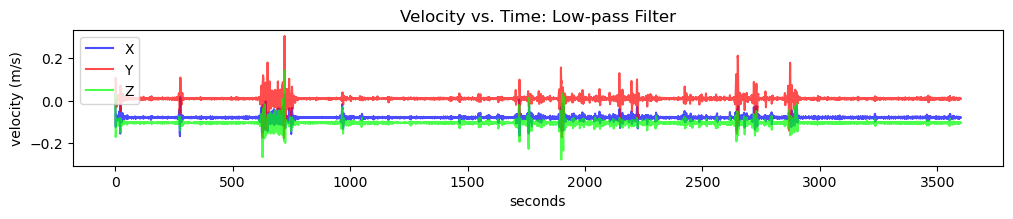

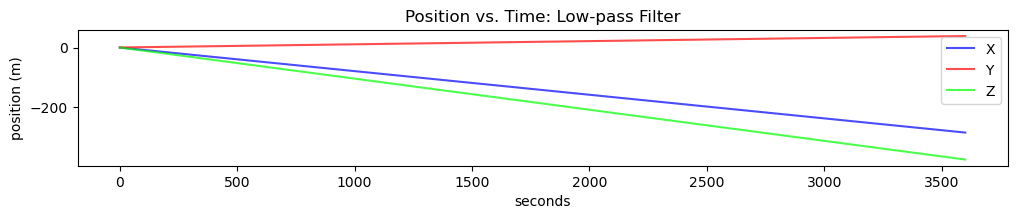

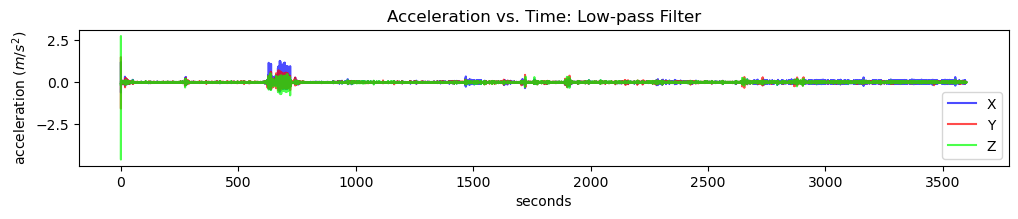

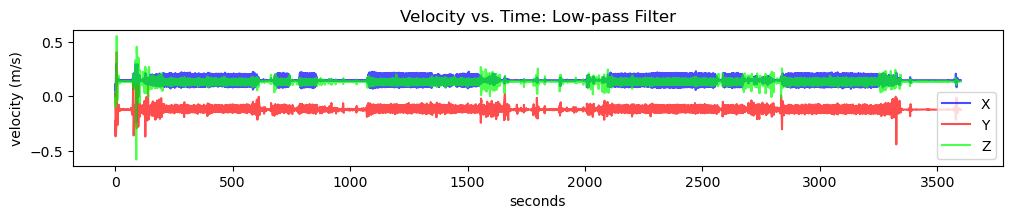

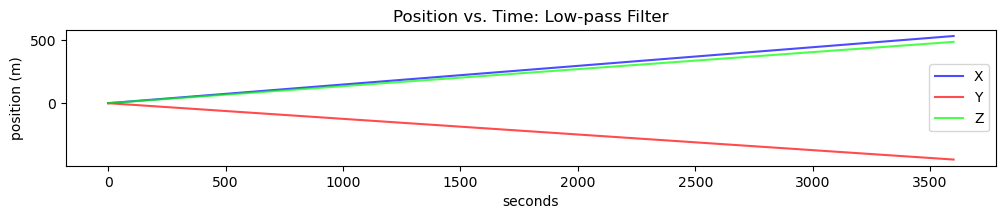

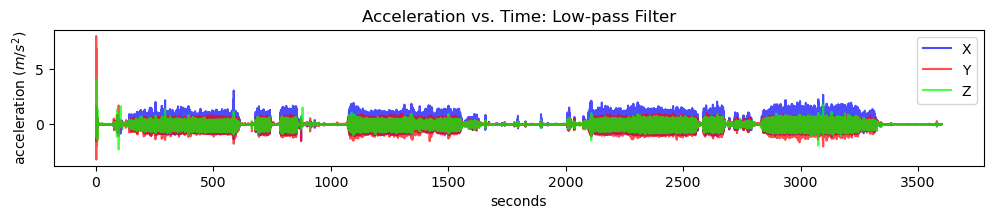

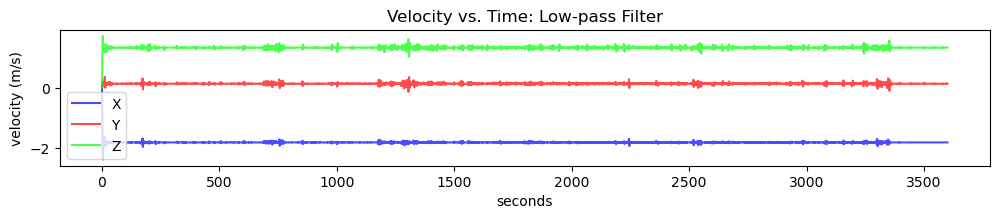

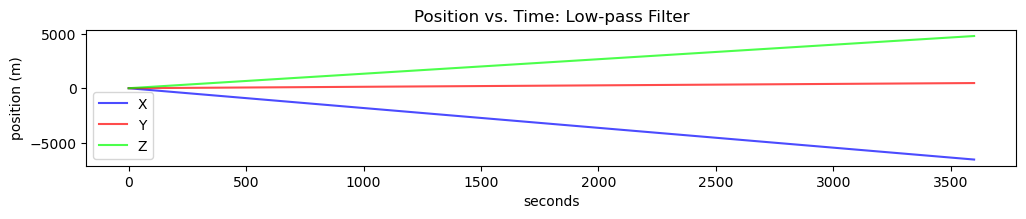

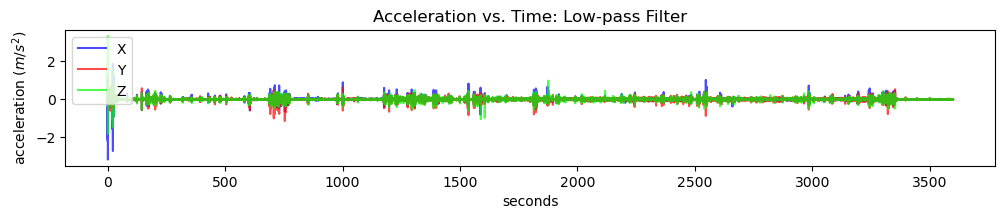

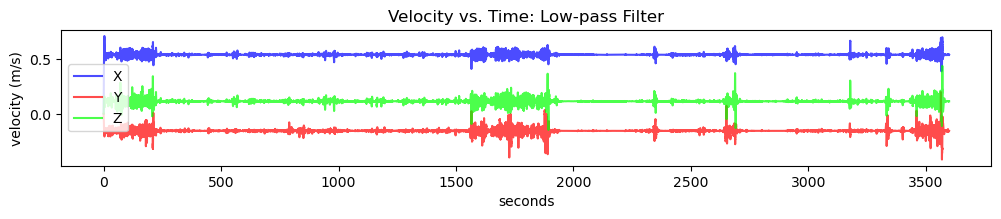

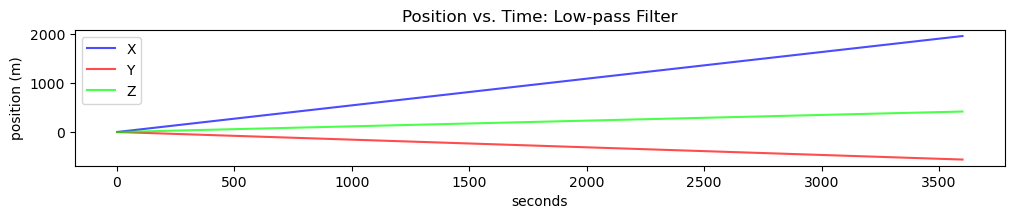

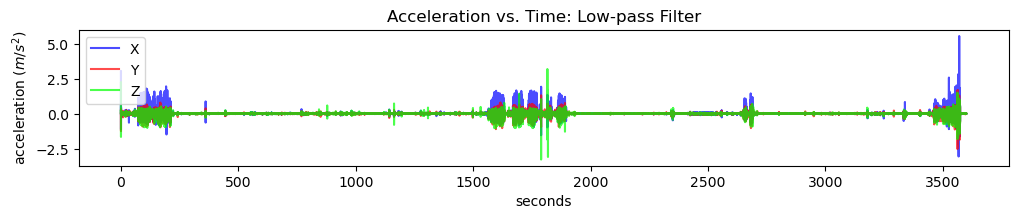

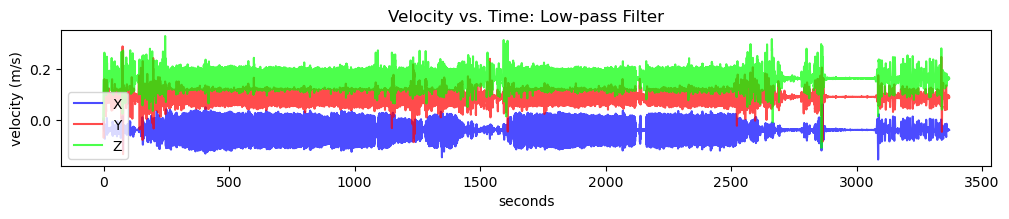

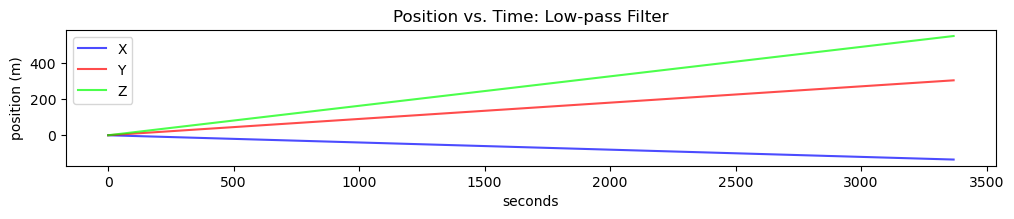

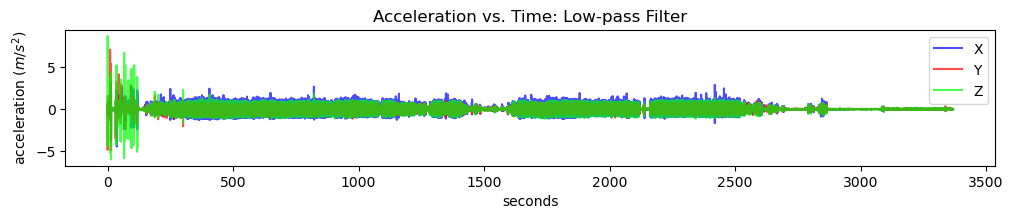

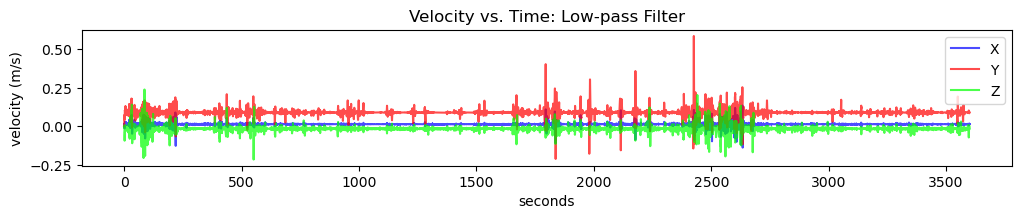

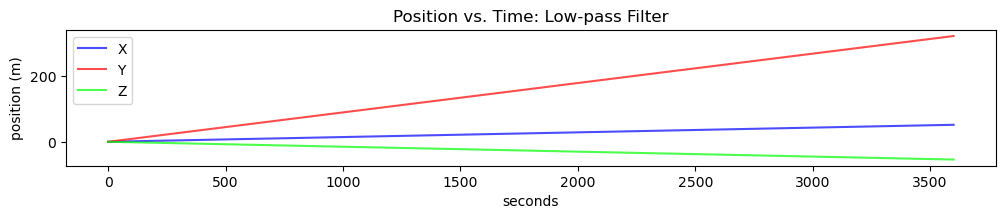

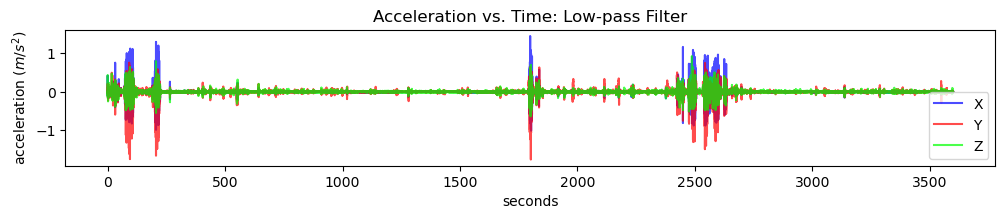

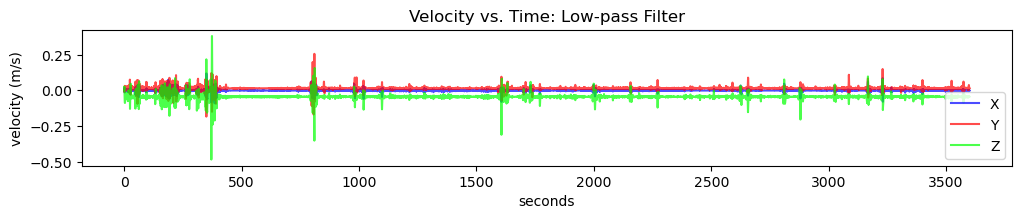

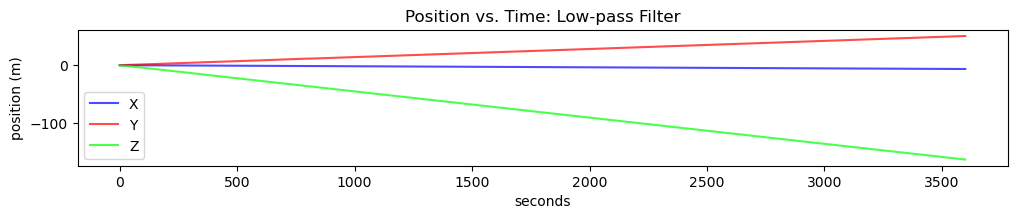

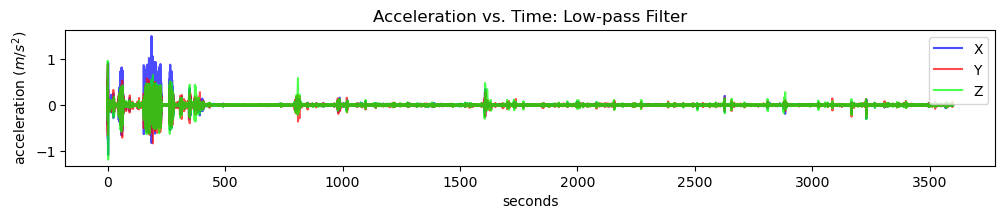

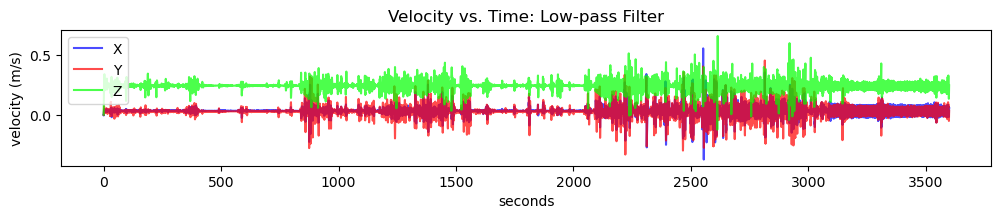

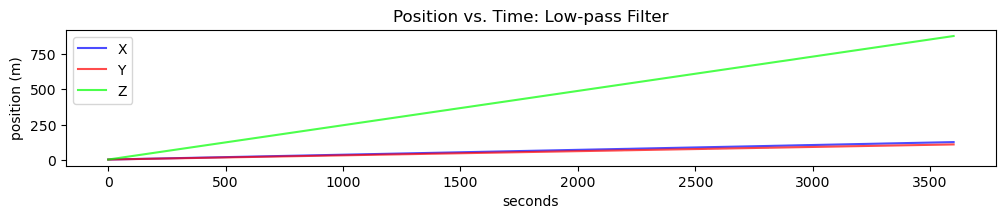

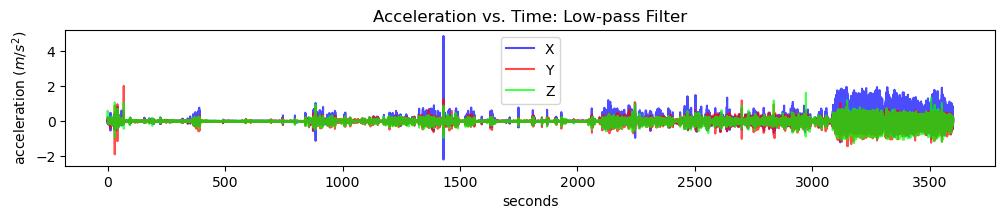

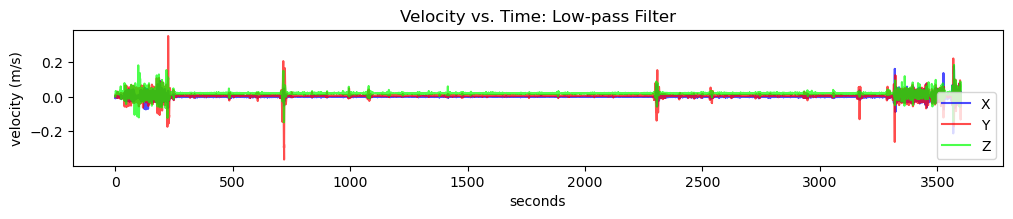

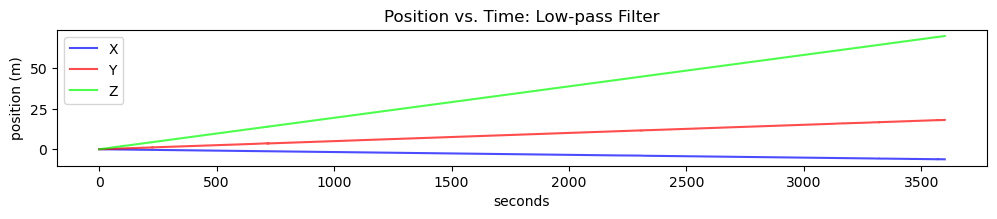

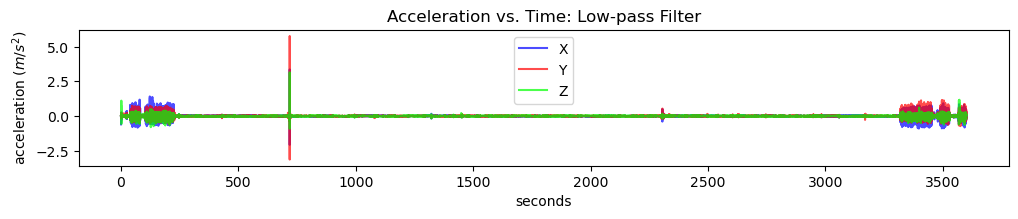

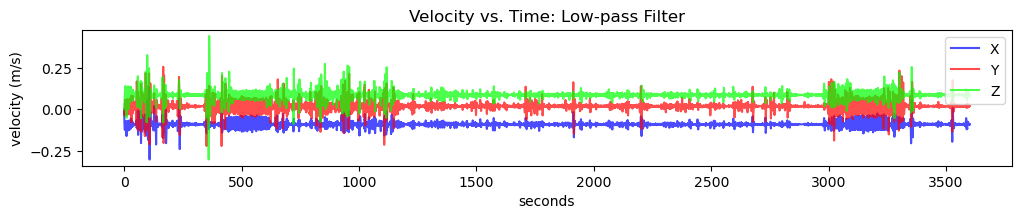

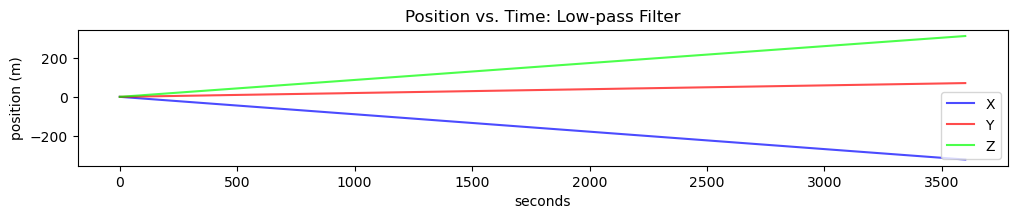

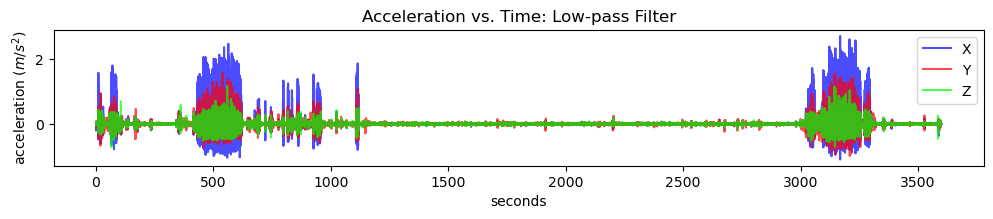

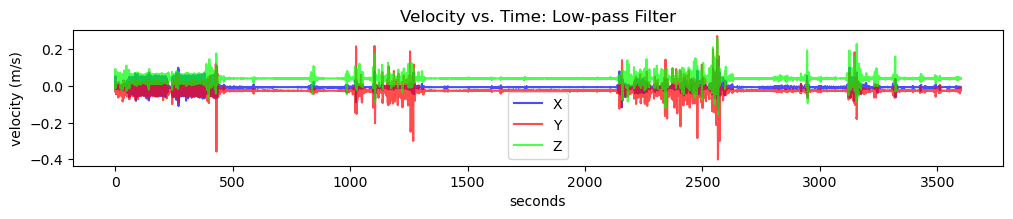

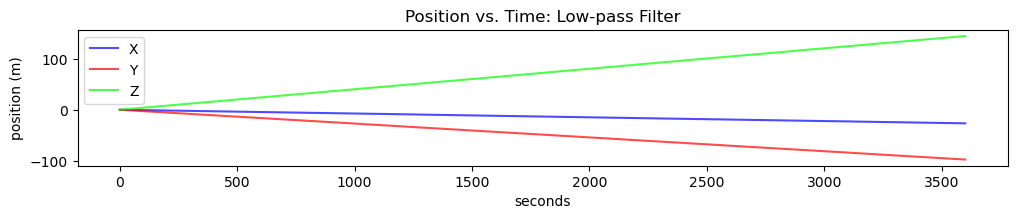

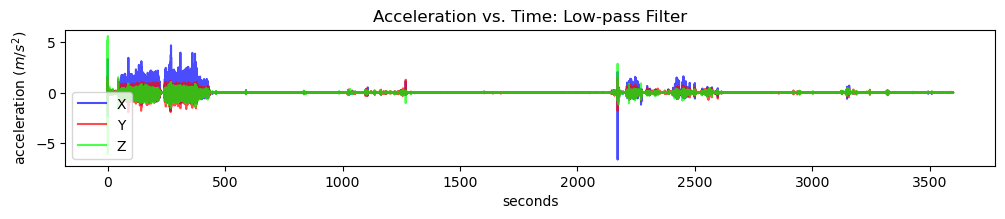

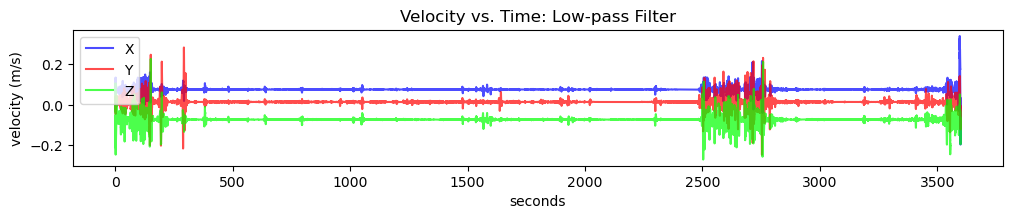

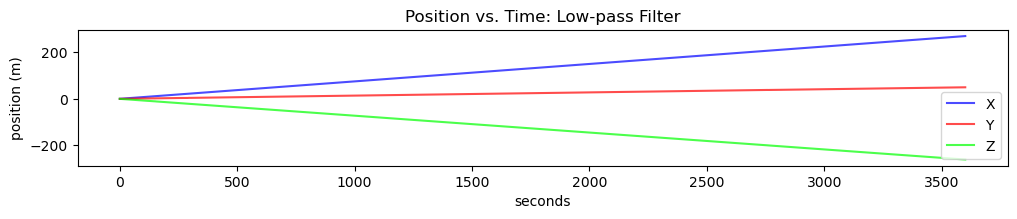

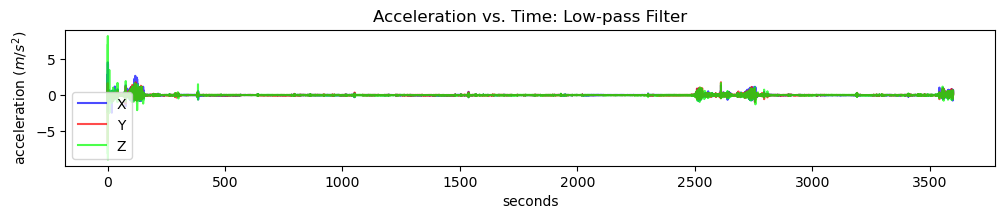

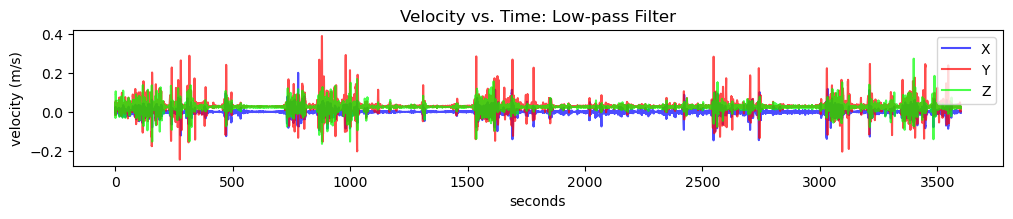

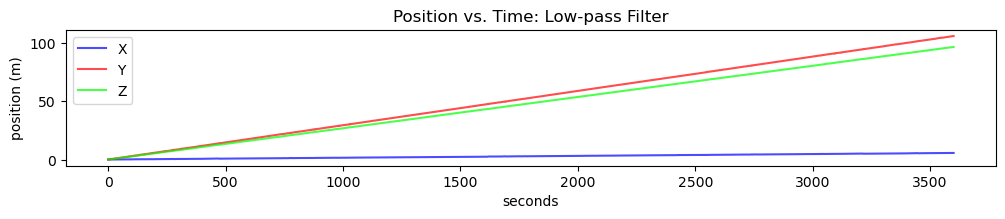

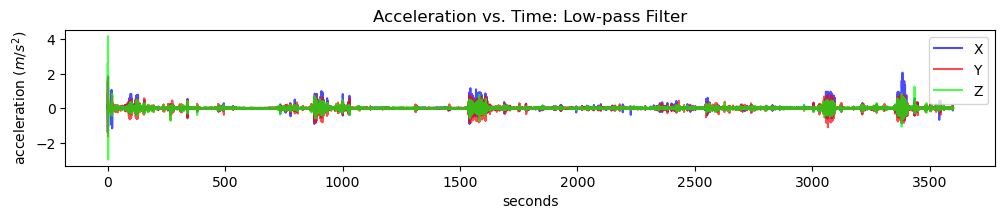

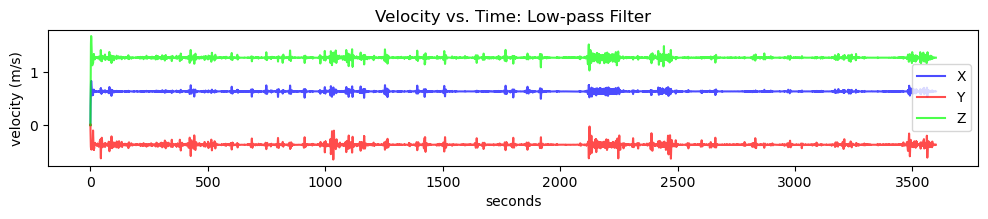

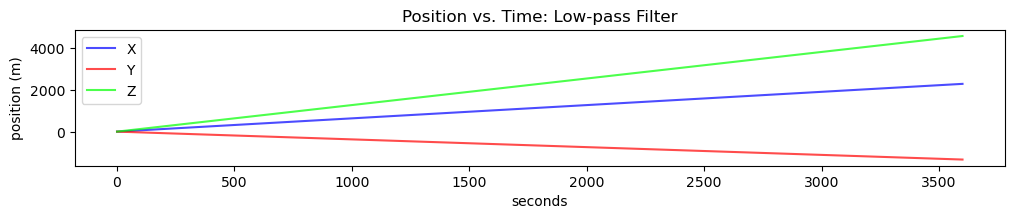

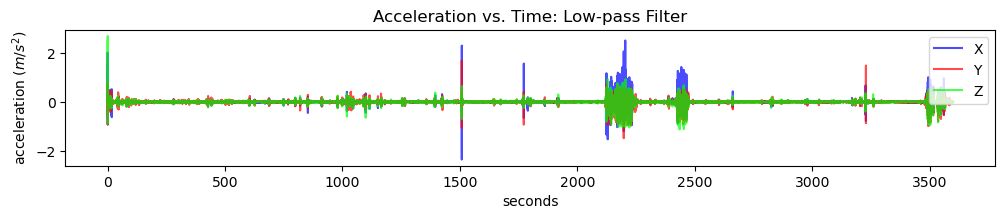

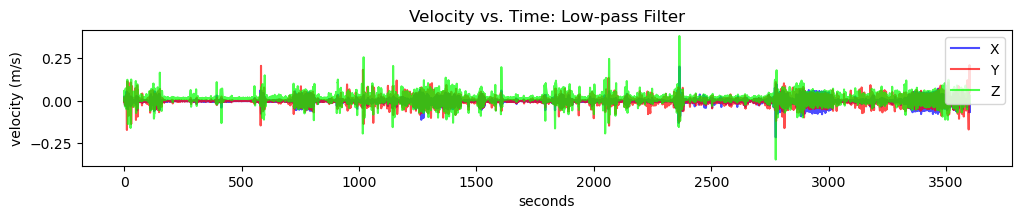

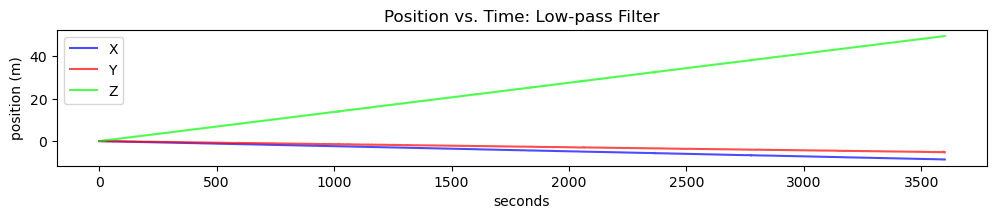

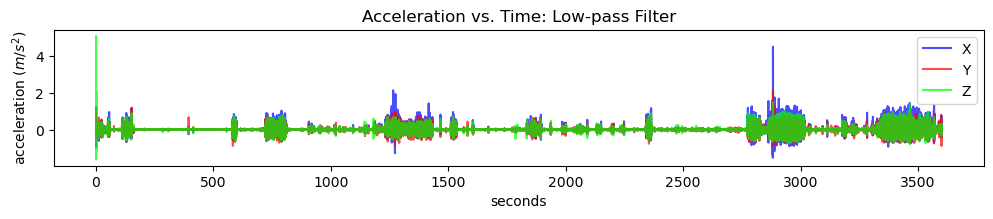

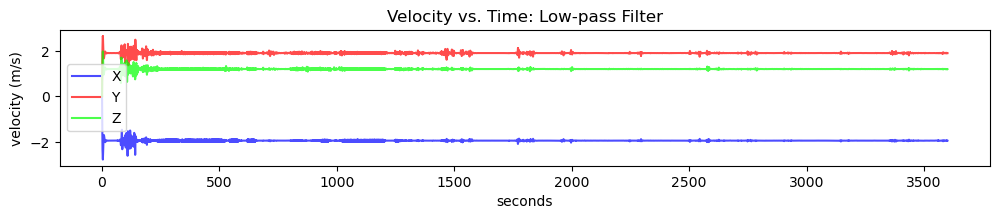

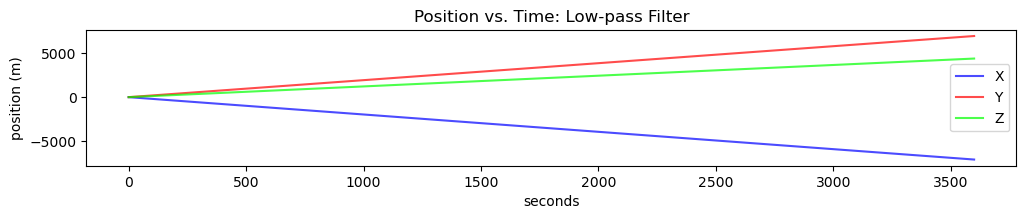

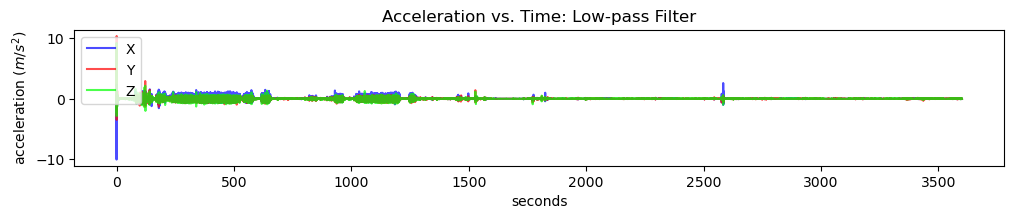

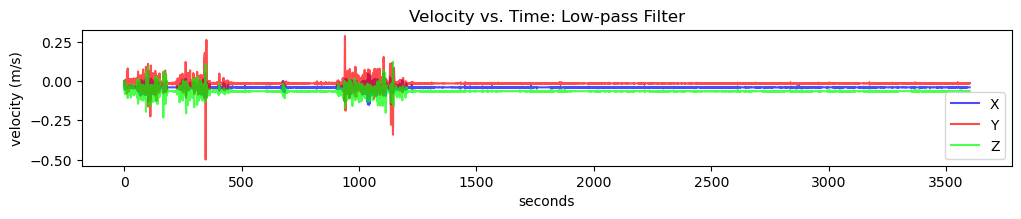

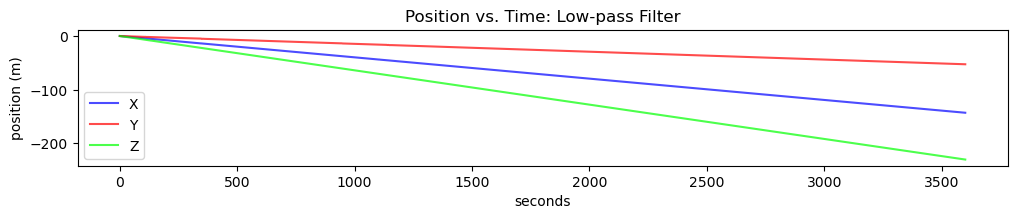

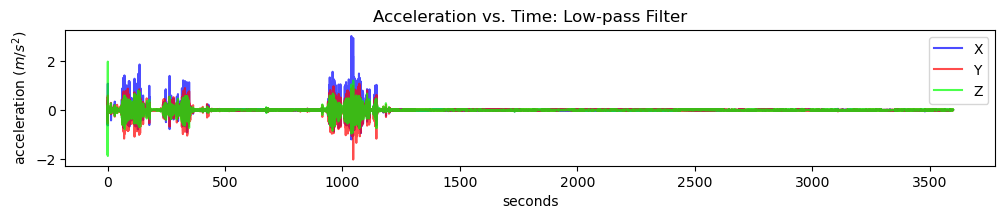

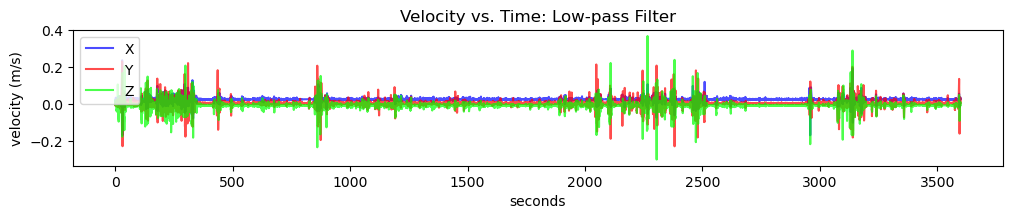

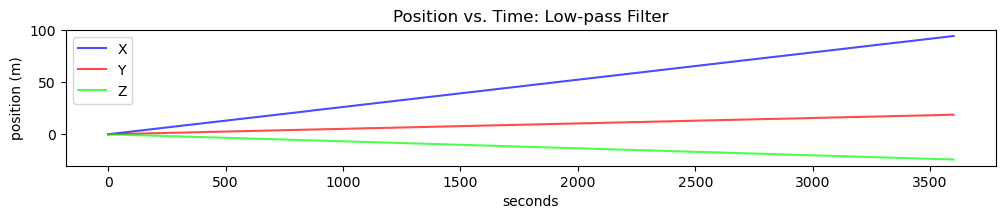

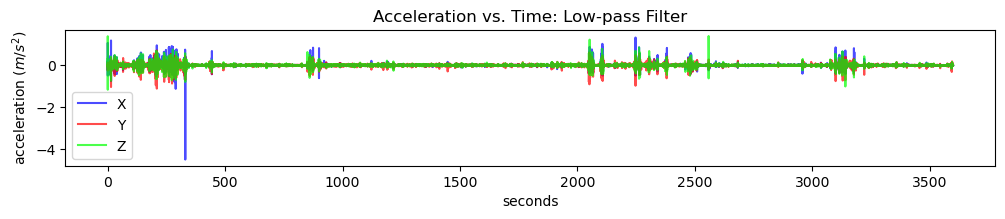

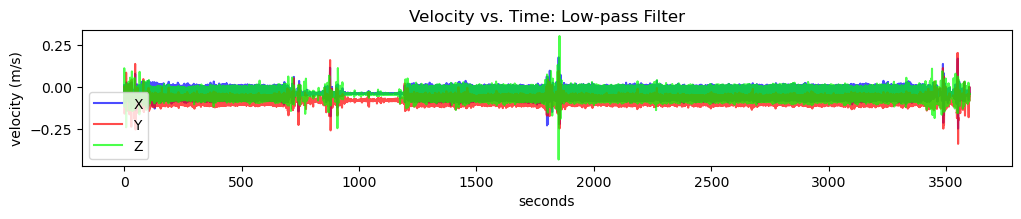

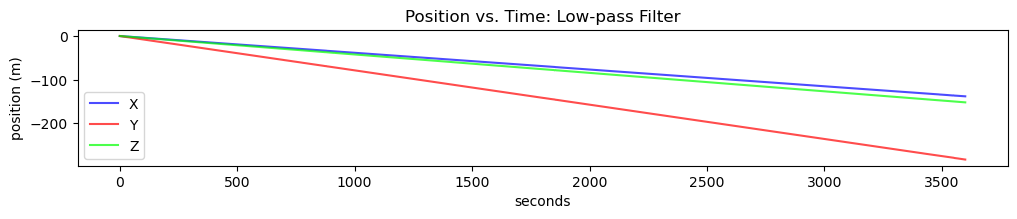

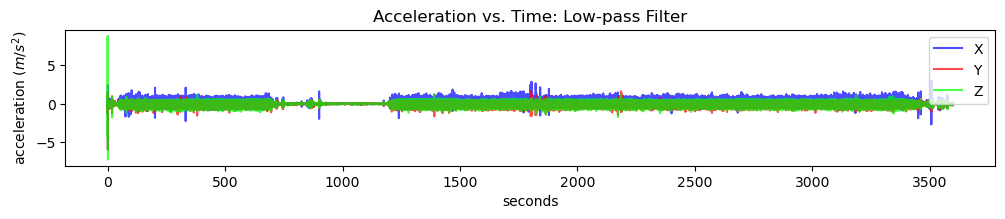

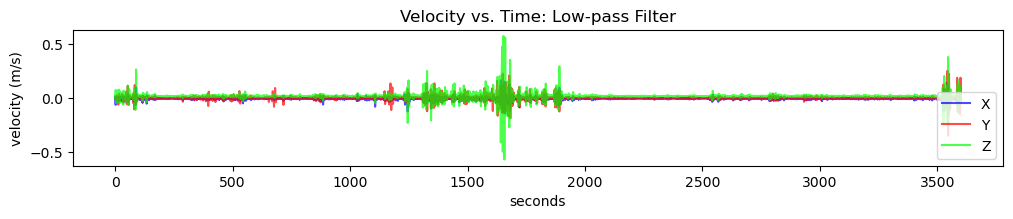

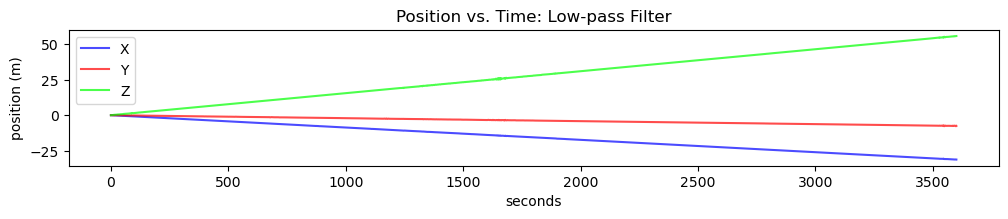

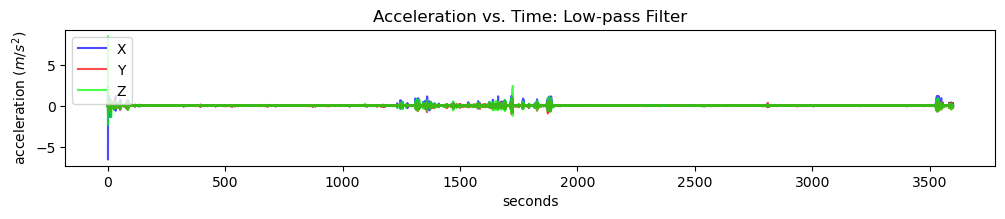

In [109]:
dir = 'Downloads/OxWalk_Dec2022/Hip_100Hz/'
cut_freq = 0.1  # increase cutoff = only get ride of high frequency noisese
x_vels=[]
y_vels=[]
z_vels=[]
xs_pos=[]
ys_pos=[]
zs_pos=[]
x_news=[]
y_news=[]
z_news=[]
times=[]
for i in os.listdir(dir):
    file_path = os.path.join(dir, i)
    data=pd.read_csv(file_path)
    data, samp_freq, time = time_params(data)
    x_new = freq_filter(data['x'].values, cut_freq, samp_freq,type='high')
    y_new = freq_filter(data['y'].values, cut_freq, samp_freq,type='high')
    z_new = freq_filter(data['z'].values-9.8, cut_freq, samp_freq,type='high') #- 9.8 b/c gravity
    x_vel, y_vel, z_vel, x_pos, y_pos, z_pos = position_velocity(x_new, y_new, z_new, time_avg)
    plotter(time, x_vel,y_vel,z_vel,x_pos,y_pos,z_pos,x_new,y_new,z_new)
    x_vels+=[x_vel]
    y_vels+=[y_vel]
    z_vels+=[z_vel]
    xs_pos+=[x_pos]
    ys_pos+=[y_pos]
    zs_pos+=[z_pos]
    x_news+=[x_new]
    y_news+=[y_new]
    z_news+=[z_new]
    times+=[time]